In [1]:
import tensorflow as tf
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
tdf=pd.read_csv(f'fashion-mnist_train.csv')
df=tdf.values

In [4]:
#generator
def build_generator():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(7*7*128,input_dim=128))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Reshape((7,7,128)))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128,5,padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128,5,padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Conv2D(1,4,padding='same',activation='sigmoid'))
    return model

1/1 [==============================] - 0s 71ms/step


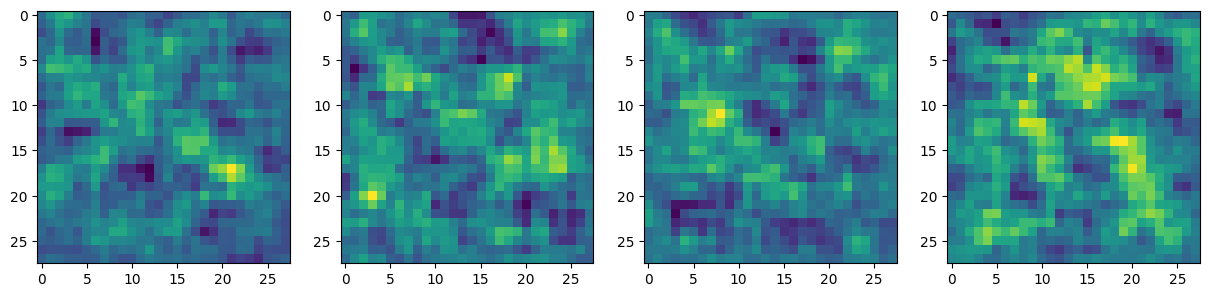

In [41]:
generator=build_generator()
# generator.summary()
pdt=generator.predict(np.random.randn(4,128))
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))  # Set ncols to 5 and adjust figsize as needed

for i in range(4):
    image = pdt[i]*255
    
    # Display the image in the last column
    
    ax[i].imshow(np.squeeze(image))  # Assuming the images are grayscale

plt.show()

In [42]:
#build Discriminator
def build_discriminator(): 
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(64, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(128, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(256, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model 

In [28]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

DATASETS!!

In [43]:
ds=tf.data.Dataset.from_tensor_slices({'image':tdf.values[:50000,1:].reshape(-1,28,28,1)})
# tdf.values[:,1:].reshape(-1,28,28,1)
# i=ds.as_numpy_iterator()

In [44]:
i=ds.as_numpy_iterator()

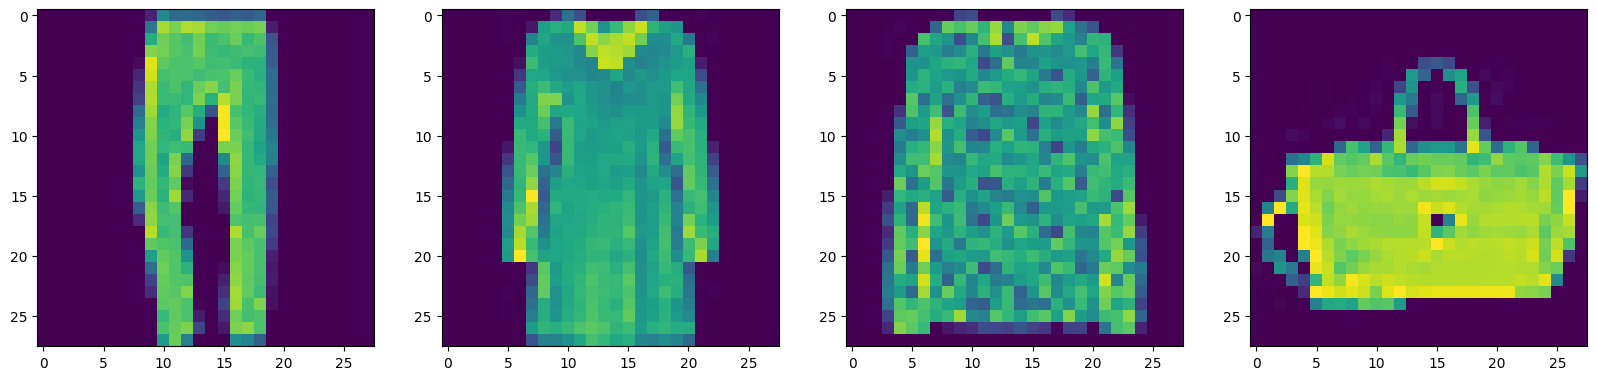

In [63]:
# i=ds.as_numpy_iterator()
fix,ax=plt.subplots(ncols=4,figsize=(20,20))
for j in range(4):
    sample=i.next()
    ax[j].imshow(np.squeeze(sample['image']))
    # print(sample['label'])


In [32]:
def scale(data):
    image=data['image']
    return image/255

In [33]:
ds=ds.map(scale)
ds=ds.cache()
ds=ds.shuffle(30000)
ds=ds.batch(128)
ds=ds.prefetch(64)
# itr=ds.as_numpy_iterator()

In [34]:
i=ds.as_numpy_iterator()

In [35]:
i.next().shape

(128, 28, 28, 1)

TRAINING LOOP

In [36]:
g_opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
d_opt=tf.keras.optimizers.Adam(learning_rate=0.00001)
g_loss=tf.keras.losses.BinaryCrossentropy()
d_loss=tf.keras.losses.BinaryCrossentropy()

In [37]:
class FashionGAN(tf.keras.models.Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [38]:
fashgan = FashionGAN(generator, discriminator)

In [39]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [40]:
import os

In [41]:
class ModelMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save( f'images\generated_img_{epoch}_{i}.png')

In [42]:
hist=fashgan.fit(ds,epochs=1000,callbacks=[ModelMonitor()])

391/391 [==============================] - 71s 181ms/step - d_loss: 0.6928 - g_loss: 0.6946
Epoch 714/1000
391/391 [==============================] - 70s 180ms/step - d_loss: 0.6926 - g_loss: 0.6958
Epoch 715/1000
391/391 [==============================] - 70s 179ms/step - d_loss: 0.6928 - g_loss: 0.6955
Epoch 716/1000
391/391 [==============================] - 70s 179ms/step - d_loss: 0.6925 - g_loss: 0.6973
Epoch 717/1000
391/391 [==============================] - 70s 179ms/step - d_loss: 0.6929 - g_loss: 0.6966
Epoch 718/1000
391/391 [==============================] - 70s 179ms/step - d_loss: 0.6927 - g_loss: 0.6974
Epoch 719/1000
391/391 [==============================] - 70s 179ms/step - d_loss: 0.6928 - g_loss: 0.6969
Epoch 720/1000
391/391 [==============================] - 70s 179ms/step - d_loss: 0.6928 - g_loss: 0.6943
Epoch 721/1000
391/391 [==============================] - 70s 179ms/step - d_loss: 0.6927 - g_loss: 0.6958
Epoch 722/1000
391/391 [============================

In [20]:
noise_real = 0.25*tf.random.uniform((28,28,1))
noise_real

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[2.24407822e-01],
        [4.40937579e-02],
        [2.45502919e-01],
        [2.33938187e-01],
        [1.10162735e-01],
        [1.52122170e-01],
        [1.91207975e-01],
        [2.43768573e-01],
        [3.51108015e-02],
        [5.44786751e-02],
        [2.32585490e-01],
        [1.84643000e-01],
        [1.49779022e-02],
        [1.33575261e-01],
        [2.00688243e-02],
        [1.01568222e-01],
        [1.80012077e-01],
        [4.62957919e-02],
        [2.31759489e-01],
        [2.24912703e-01],
        [5.17874062e-02],
        [8.05862844e-02],
        [1.55221492e-01],
        [2.69868374e-02],
        [2.10522860e-01],
        [1.98161691e-01],
        [3.60364914e-02],
        [1.82364792e-01]],

       [[6.73202872e-02],
        [1.23509258e-01],
        [1.45119190e-01],
        [6.73659444e-02],
        [2.16076225e-01],
        [4.54635024e-02],
        [1.60754234e-01],
        [1.72558099e-01],
        [

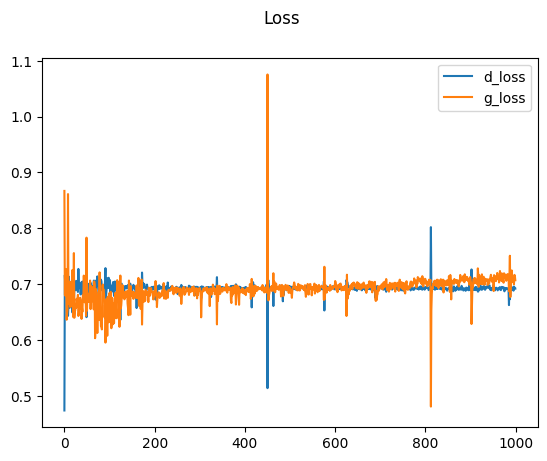

In [43]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [48]:
discriminator.save('discnator.h5')
generator.save('genetor.h5')

In [6]:
imgs = generator.predict(tf.random.normal((16, 128)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

NameError: name 'generator' is not defined

In [50]:
import pickle

pickle.dump(generator, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://8b3b3490-c722-4ef1-88cb-5f912c809ef6/assets


INFO:tensorflow:Assets written to: ram://8b3b3490-c722-4ef1-88cb-5f912c809ef6/assets


1/1 [==============================] - 0s 284ms/step


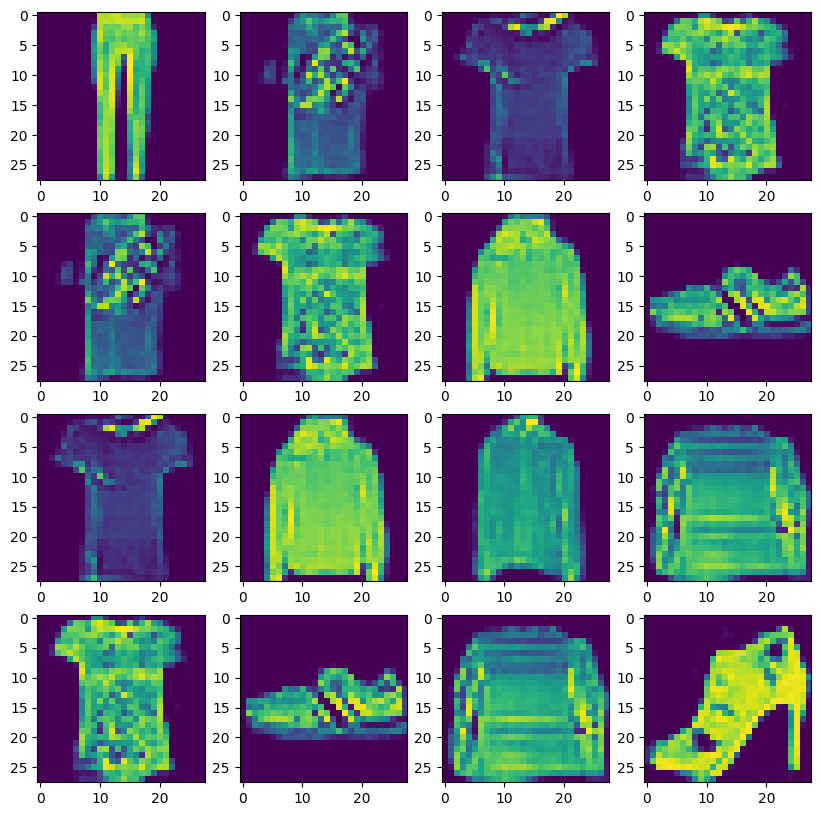

In [5]:
new_model = tf.keras.models.load_model('genetor.h5')
imgs = new_model.predict(tf.random.normal((16, 128)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])



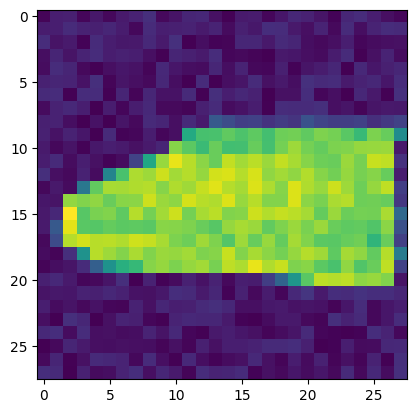

In [66]:
plt.imshow(imgs[0]+0.15*tf.random.uniform((28,28,1)))